# Speech Processing
# Voice command recognition system

## Some Needed libraries

At the begining, we need to import needed libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
import pyaudio
import wave
from pydub import AudioSegment
import glob
import librosa
import noisereduce as nr
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

## Recorder

Here we define the Recorder class to record our voice dataset

In [4]:
@dataclass
class StreamParams():
    format: int = pyaudio.paInt16 #equivalent of bit depth
    channels: int = 1 #number of chanels
    rate: int = 44100 #sample rate
    frames_per_buffer: int = 1024 #frame want to be read for each buffer
    #Identify if the stream is type input or output
    input: bool = True
    output: bool = False

    def to_dict(self) -> dict:
        return asdict(self)

class Recorder():

    def __init__(self, stream_params: StreamParams) -> None:
        self.stream_params = stream_params
        self._pyaudio = None # for pyauodio object
        self._stream = None # for the stream depth we will be reading from
        self._wav_file = None # for the wav file

    def record(self, duration: int, save_path: str, stop_flag: bool) -> None:
        self.flag = stop_flag
        print("Start recording...")
        self._create_recording_resources(save_path)
        self._write_wav_file_reading_from_stream(duration)
        self._close_recording_resources()
        print("Recording Stoped\n")

    def _create_recording_resources(self, save_path: str) -> None:
        self._pyaudio = pyaudio.PyAudio() #Provide method to init and terminate port I/O and open/close strings
        self._stream = self._pyaudio.open(**self.stream_params.to_dict()) #Init a pyaoudio stream object
        self._create_wav_file(save_path)

    def _create_wav_file(self, save_path: str):
        self._wav_file = wave.open(save_path, "wb")
        self._wav_file.setnchannels(self.stream_params.channels) #set the number of channels
        self._wav_file.setsampwidth(self._pyaudio.get_sample_size(self.stream_params.format)) #set the sample width
        self._wav_file.setframerate(self.stream_params.rate) #set the frame rate
    
    def _write_wav_file_reading_from_stream(self, duration: int) -> None:
        for _ in range(int(self.stream_params.rate * duration / self.stream_params.frames_per_buffer)):
            if self.flag: # this is an option to stop the recording with button
                break 
            else:
                audio_data = self._stream.read(self.stream_params.frames_per_buffer)
                self._wav_file.writeframes(audio_data)

    def _close_recording_resources(self) -> None:
        self._wav_file.close()
        self._stream.close()
        self._pyaudio.terminate()

We have 2 classes, one for audios that we say `TV` and the other for audios that we say `Refrigerator` on them. All audio files are recorded in `Farsi`

In [5]:
stream_params = StreamParams(format=pyaudio.paInt16 ,rate=16000)
recorder = Recorder(stream_params)

### Recording `TV` class

Here we record `TV` class:

In [8]:
for i in range(30):
    print(f"Press Enter to record the audio file number {i}:")
    input(f"Press Enter to record the audio file number {i}:") 
    path = './TV/TV'+str(i)+'.wav'
    recorder.record(duration=1.5, save_path=path, stop_flag=False)

Press Enter to record the audio file number 0:


### Recording `Refrigerator` class

Here we record `Refrigerator` class:

In [9]:
for i in range(30):
    print(f"Press Enter to record the audio file number {i}:")
    input(f"Press Enter to record the audio file number {i}:") 
    path = './Ref/Ref'+str(i)+'.wav'
    recorder.record(duration=1.5, save_path=path, stop_flag=False)

Press Enter to record the audio file number 0:
Start recording...
Recording Stoped

Press Enter to record the audio file number 1:
Start recording...
Recording Stoped

Press Enter to record the audio file number 2:
Start recording...
Recording Stoped

Press Enter to record the audio file number 3:
Start recording...
Recording Stoped

Press Enter to record the audio file number 4:
Start recording...
Recording Stoped

Press Enter to record the audio file number 5:
Start recording...
Recording Stoped

Press Enter to record the audio file number 6:
Start recording...
Recording Stoped

Press Enter to record the audio file number 7:
Start recording...
Recording Stoped

Press Enter to record the audio file number 8:
Start recording...
Recording Stoped

Press Enter to record the audio file number 9:
Start recording...
Recording Stoped

Press Enter to record the audio file number 10:
Start recording...
Recording Stoped

Press Enter to record the audio file number 11:
Start recording...
Recordin

## Open recorded files

Now that we recorded our dataset, we need to open the audio files as arrays so we can work with them

In [7]:
path_TV = './TV'
path_Ref = './ref'
sr = 16000
filenames_tv = glob.glob(path_TV + "/*.wav")
filenames_ref = glob.glob(path_Ref + "/*.wav")
tv_sound = np.array([librosa.load(i,sr=sr)[0] for i in filenames_tv])
ref_sound = np.array([librosa.load(i,sr=sr)[0] for i in filenames_ref])

And here we show a random sample of each class:

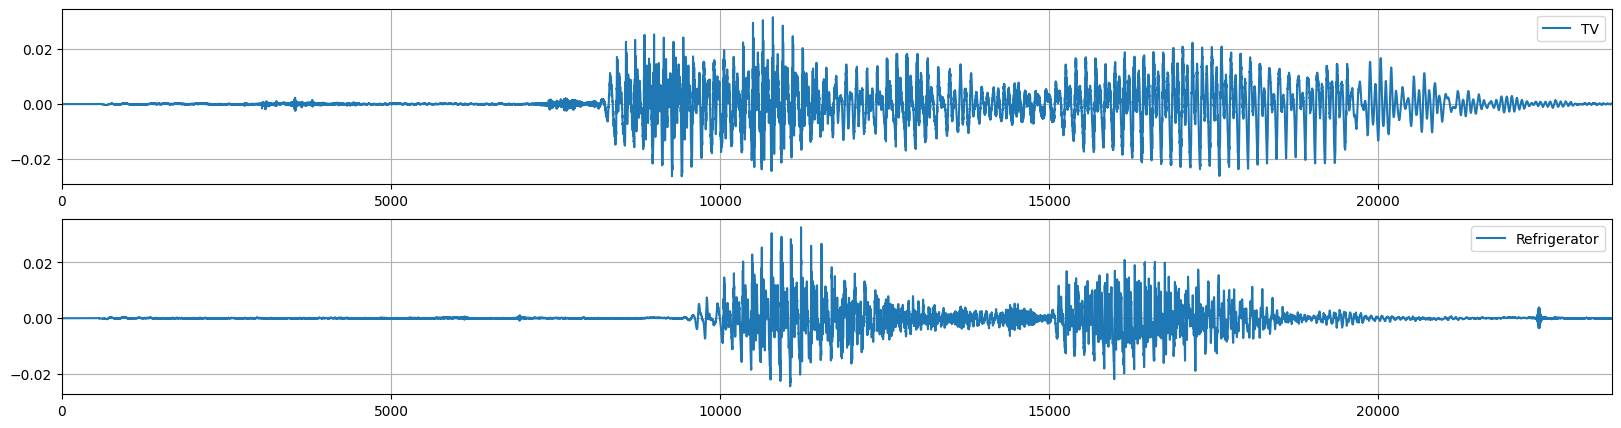

In [8]:
np.random.seed(60)
N = np.random.randint(0,29)
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.xlim(0,len(tv_sound[N]))
plt.plot(tv_sound[N],label='TV')
plt.legend()
plt.grid()
plt.subplot(212)
plt.xlim(0,len(ref_sound[N]))
plt.plot(ref_sound[N],label='Refrigerator')
plt.legend()
plt.grid()
plt.show()

In [9]:
print(f'Data shape of TV: {tv_sound.shape}')
print(f'Data shape of Refrigerator: {ref_sound.shape}')

Data shape of TV: (30, 23552)
Data shape of Refrigerator: (30, 23552)


## Preprocessing

### Denoising

First step of preprocessing is to remove data noises as below:

In [10]:
tv_sound_nr = np.array([nr.reduce_noise(i,sr) for i in tv_sound])
ref_sound_nr = np.array([nr.reduce_noise(i,sr) for i in ref_sound])

And here we show a random sample of each class:

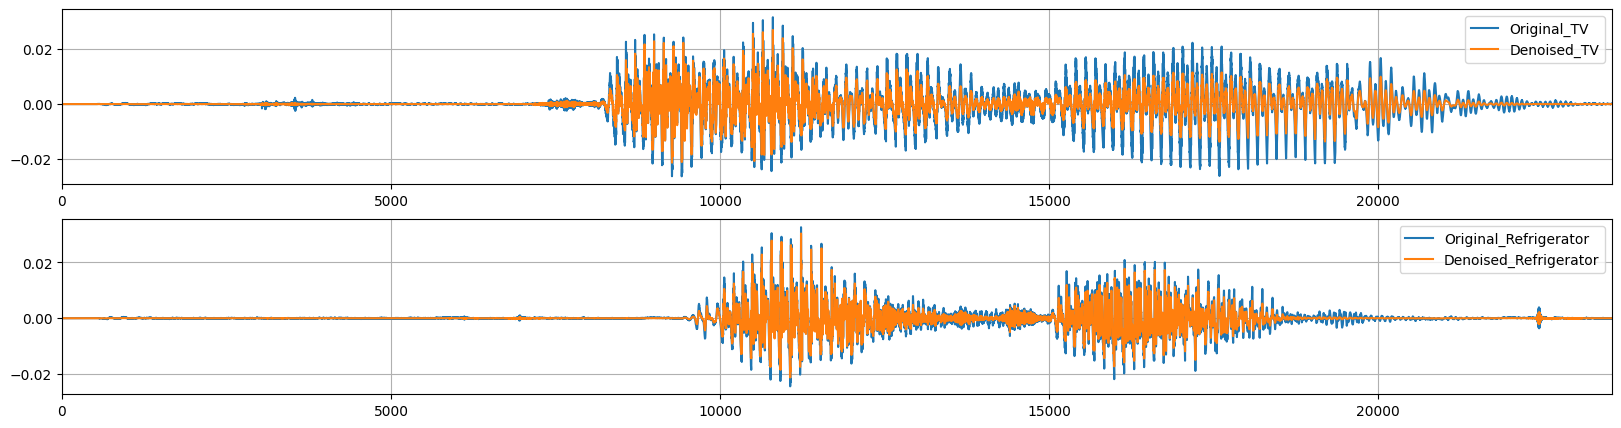

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.xlim(0,len(tv_sound[N]))
plt.plot(tv_sound[N],label='Original_TV')
plt.plot(tv_sound_nr[N],label='Denoised_TV')
plt.legend()
plt.grid()
plt.subplot(212)
plt.xlim(0,len(ref_sound[N]))
plt.plot(ref_sound[N],label='Original_Refrigerator')
plt.plot(ref_sound_nr[N],label='Denoised_Refrigerator')
plt.legend()
plt.grid()
plt.show()

In [12]:
print(f'Data shape of TV dataframe after denoising: {tv_sound_nr.shape}')
print(f'Data shape of Refrigerator dataframe after denoising: {ref_sound_nr.shape}')

Data shape of TV dataframe after denoising: (30, 23552)
Data shape of Refrigerator dataframe after denoising: (30, 23552)


### Scaling

Next step is scaling so our dataset will be a normal dataset for training and evaliuation

In [13]:
tv_sound_nr_scaled = np.array([i/max(i) for i in tv_sound])
ref_sound_nr_scaled = np.array([i/max(i) for i in ref_sound])

And here we show a random sample of each class:

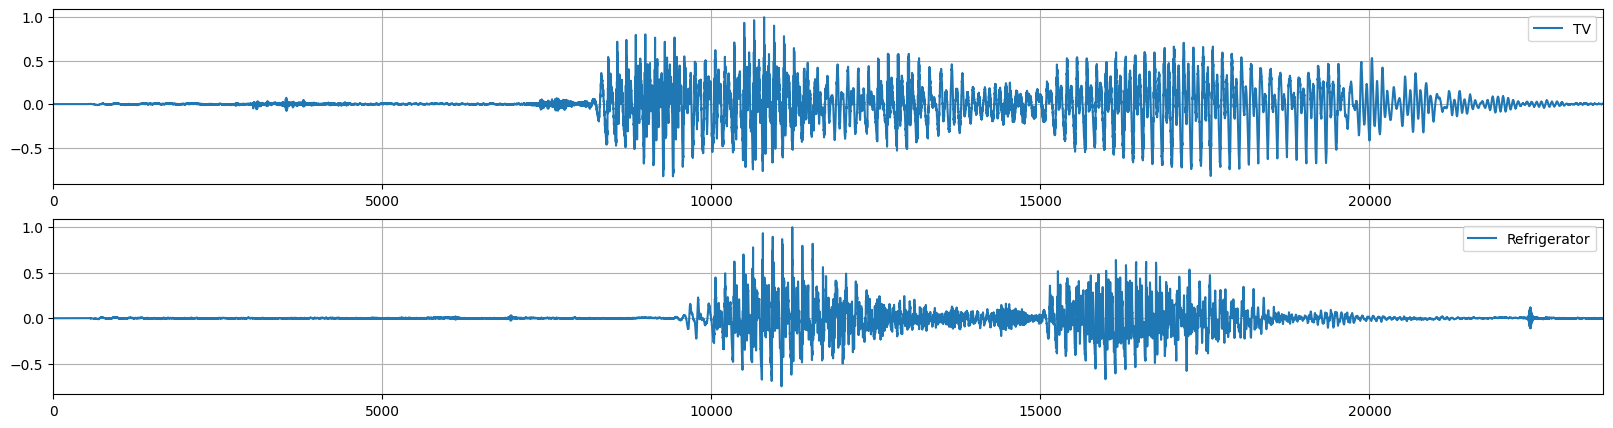

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.xlim(0,len(tv_sound_nr_scaled[N]))
plt.plot(tv_sound_nr_scaled[N],label='TV')
plt.legend()
plt.grid()
plt.subplot(212)
plt.xlim(0,len(ref_sound_nr_scaled[N]))
plt.plot(ref_sound_nr_scaled[N],label='Refrigerator')
plt.legend()
plt.grid()
plt.show()

## Feature Extraction

### Mel Frequency Cepstral Coefficients

The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope

In [67]:
tv_mfcc = np.array([librosa.feature.mfcc(i,sr=sr,n_mfcc=12) for i in tv_sound_nr_scaled]).mean(2)
ref_mfcc = np.array([librosa.feature.mfcc(i,sr=sr,n_mfcc=12) for i in ref_sound_nr_scaled]).mean(2)

C:\Users\Alireza\AppData\Local\Temp\ipykernel_7676\3446641700.py:1: FutureWarning: Pass y=[ 0.          0.         -0.00046211 ... -0.01524954 -0.01617375
 -0.01709797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  tv_mfcc = np.array([librosa.feature.mfcc(i,sr=sr,n_mfcc=12) for i in tv_sound_nr_scaled]).mean(2)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_7676\3446641700.py:1: FutureWarning: Pass y=[ 0.          0.         -0.00148148 ... -0.00444444 -0.00592593
 -0.00592593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  tv_mfcc = np.array([librosa.feature.mfcc(i,sr=sr,n_mfcc=12) for i in tv_sound_nr_scaled]).mean(2)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_7676\3446641700.py:1: FutureWarning: Pass y=[ 0.          0.         -0.00076511 ... -0.00229533 -0.00153022
 -0.00153022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  

In [68]:
print(f'Data shape of TV mfcc dataset: {tv_mfcc.shape}')
print(f'Data shape of Refrigerator mfccdataset: {ref_mfcc.shape}')

Data shape of TV mfcc dataset: (30, 12)
Data shape of Refrigerator mfccdataset: (30, 12)


## Data

Here we prepare our data so we can giv it to our model

In [69]:
X = np.concatenate([tv_mfcc,ref_mfcc])
Y = np.zeros(60)
Y[0:30] = 1

And we split our dataset into train and test sets:

In [70]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=1/3,stratify=Y)

## Model

### Training

Here we define our model with 8 gaussian components:

In [71]:
gmm = GaussianMixture(n_components=8,random_state=0)

Now we fit the model for our our train set

In [72]:
gmm.fit(x_train)

GaussianMixture(n_components=8, random_state=0)

### Evaliuation

Here we predict our test set

In [73]:
p = gmm.predict(x_test)

And to see if our model works, we show a confusion matrix of predicted values and true labels

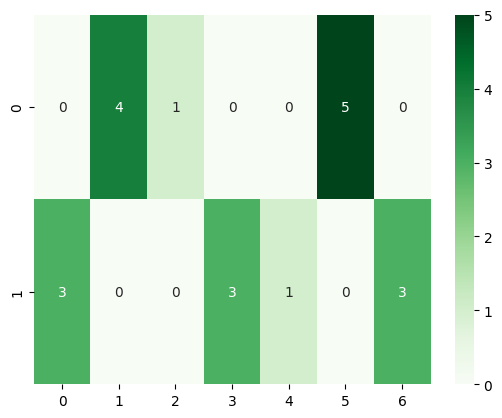

In [74]:
heatmap(confusion_matrix(y_test,p)[0:2],annot=True, cmap=plt.cm.Greens)
plt.show()